In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

c:\users\dq315\appdata\local\continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

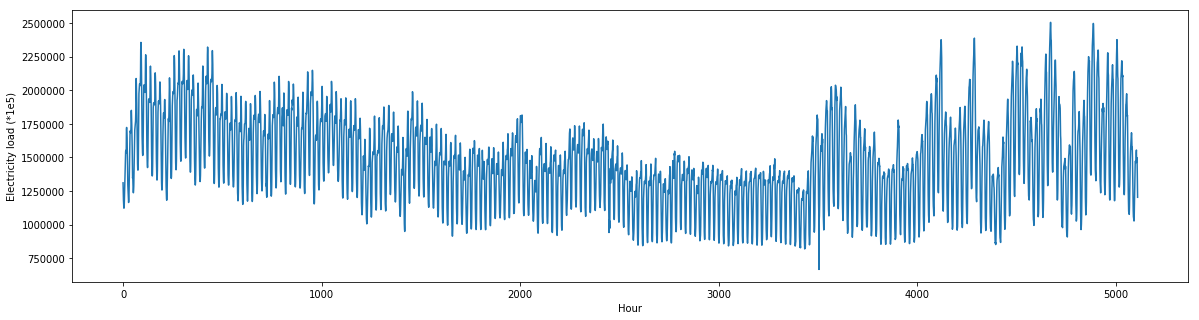

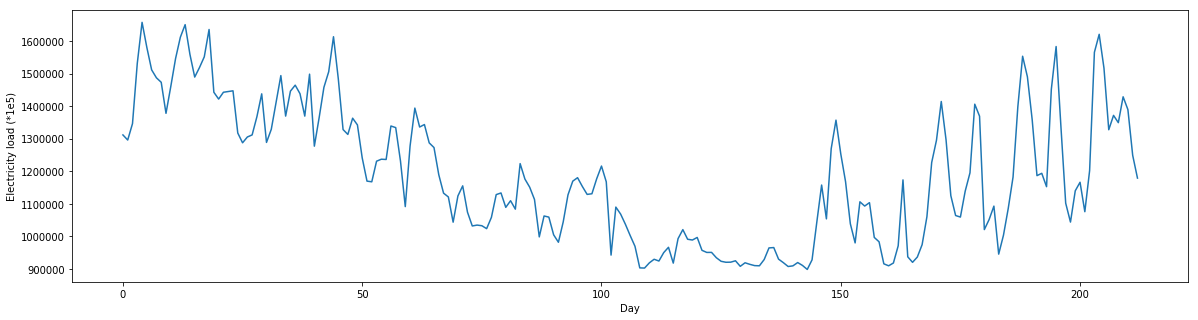

In [3]:
# random seed
np.random.seed(1234)

# load raw data
df_raw = pd.read_csv('hourly_load_2016.csv', header=None)
# numpy array
df_raw_array = df_raw.values
# plot original hourly load
plt.figure(1, figsize=(20, 5))
plt.plot(df_raw_array[:,1])
plt.xlabel('Hour')
plt.ylabel('Electricity load (*1e5)')
plt.show()

# daily load
list_daily_load = [df_raw_array[i,:] for i in range(0, len(df_raw)) if i % 24 == 0]
# plot original daily load
plt.figure(1, figsize=(20, 5))
plt.plot(np.array(list_daily_load)[:,1])
plt.xlabel('Day')
plt.ylabel('Electricity load (*1e5)')
plt.show()

# hourly load (23 loads for each day)
list_hourly_load = [df_raw_array[i,1]/100000 for i in range(0, len(df_raw)) if i % 24 != 0]

# the length of the sequnce for predicting the future value
sequence_length = 23

In [4]:
# convert the vector to a 2D matrix
matrix_load = convertSeriesToMatrix(list_hourly_load, sequence_length)

# shift all data by mean
matrix_load = np.array(matrix_load)
shifted_value = matrix_load.mean()
matrix_load -= shifted_value
print ("Data  shape: ", matrix_load.shape)

# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_load.shape[0]))
train_set = matrix_load[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)

# the training set: the last column is the true value to compute the mean-squared-error loss
X_train = train_set[:, :-1]
y_train = train_set[:, -1] 

# the test set
X_test = matrix_load[train_row:, :-1]
y_test = matrix_load[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Data  shape:  (4877, 23)


In [5]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(output_dim=100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(output_dim=1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

# train the model
model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.'%(test_mse,len(y_test)))

c:\users\dq315\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
c:\users\dq315\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  after removing the cwd from sys.path.
c:\users\dq315\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
  import sys
c:\users\dq315\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  # This is added back by InteractiveShellApp.init_path()
c:\users\dq315\appdata\local\continuum\anaco

Train on 4169 samples, validate on 220 samples
Epoch 1/50
4169/4169 [==============================] - 2s 506us/step - loss: 7.4492 - val_loss: 5.5170
Epoch 2/50
4169/4169 [==============================] - 1s 227us/step - loss: 5.0408 - val_loss: 3.4723
Epoch 3/50
4169/4169 [==============================] - 1s 219us/step - loss: 4.1428 - val_loss: 3.5624
Epoch 4/50
4169/4169 [==============================] - 1s 216us/step - loss: 2.9858 - val_loss: 2.1792
Epoch 5/50
4169/4169 [==============================] - 1s 209us/step - loss: 2.4040 - val_loss: 2.6491
Epoch 6/50
4169/4169 [==============================] - 1s 209us/step - loss: 2.1120 - val_loss: 1.8417
Epoch 7/50
4169/4169 [==============================] - 1s 209us/step - loss: 1.7852 - val_loss: 1.4109
Epoch 8/50
4169/4169 [==============================] - 1s 212us/step - loss: 1.3865 - val_loss: 1.2744
Epoch 9/50
4169/4169 [==============================] - 1s 213us/step - loss: 1.3868 - val_loss: 0.8908
Epoch 10/50
4169/

In [6]:
# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

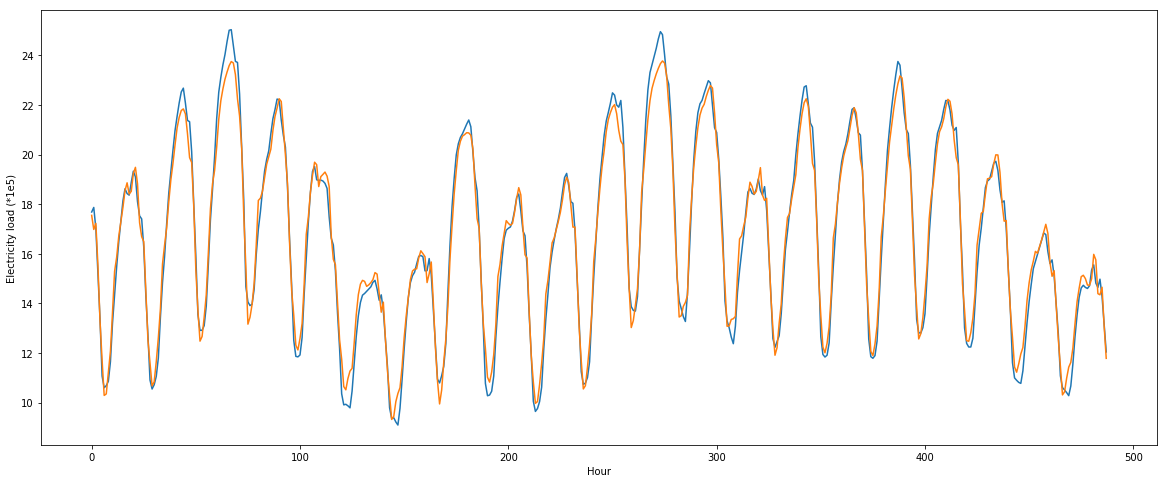

In [7]:
# plot the results
fig = plt.figure(1, figsize=(20, 8))
plt.plot(y_test + shifted_value)
plt.plot(predicted_values + shifted_value)
plt.xlabel('Hour')
plt.ylabel('Electricity load (*1e5)')
plt.show()
fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')